# DCEGM Upper Envelope
## ["The endogenous grid method for discrete-continuous dynamic choice models with (or without) taste shocks"](https://onlinelibrary.wiley.com/doi/abs/10.3982/QE643)

<p style="text-align: center;"><small><small><small>For the following badges: GitHub does not allow click-through redirects; right-click to get the link, then paste into navigation bar</small></small></small></p>

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/dcegm-upper-envelope#launch)



This notebook provides a simple introduction to the "DCEGM" algorithm <cite data-cite="6202365/4F64GG8F"></cite>. DCEGM extends the EGM method proposed in <cite data-cite="6202365/HQ6H9JEI"></cite> to problems with both continuous (e.g. consumption) and discrete (e.g. retirement) decisions.

The main challenge for the EGM algorithm in discrete-continuous problems is that the discrete decisions generate "kinks" in the value function, making it non-concave and rendering the first order condition used by EGM a necessary but not sufficient for optimality. In practice, this causes the EGM inversion step to produce (resource, consumption) points that are not optimal. DCEGM incorporates a method to filter the points produced by EGM so that only the truly optimal ones are used in producing an approximation to the solution.

This filtering process consists mainly of computing "upper-envelopes" of the candidate points: lines that are made up only of the points with the higher values.

This notebook presents HARK's tool for calculating upper-envelopes and then uses it to solve a simple three-period discrete-continuous problem using DCEGM.

# Upper envelopes

Start by importing the tools.

In [1]:
# imports
import warnings

warnings.filterwarnings("ignore")
from HARK.rewards import CRRAutility, CRRAutilityP, CRRAutilityP_inv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# here for now, should be
# from HARK import discontools or whatever name is chosen
from HARK.interpolation import LinearInterp
from HARK.dcegm import calc_nondecreasing_segments, upper_envelope

Applying EGM to value functions with kinks, as the ones that result from discrete-continuous problems, will often result in grids for market resources that are not monotonic and candidate choices at those points that are sub-optimal.
Consider the following example output.

Text(0, 0.5, 'Value')

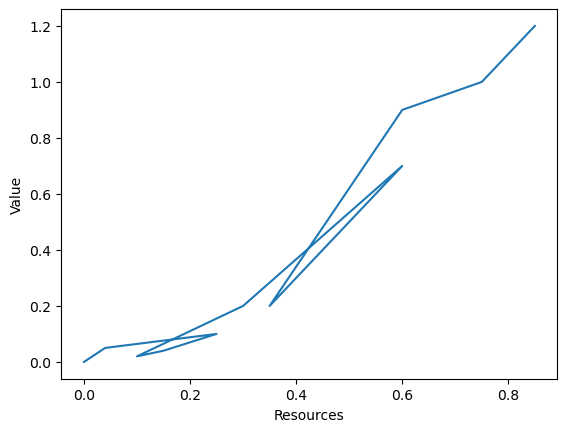

In [3]:
m_egm = np.array([0.0, 0.04, 0.25, 0.15, 0.1, 0.3, 0.6, 0.5, 0.35, 0.6, 0.75, 0.85])
c_egm = np.array([0.0, 0.03, 0.1, 0.07, 0.05, 0.36, 0.4, 0.6, 0.8, 0.9, 0.9, 0.9])
vt_egm = np.array([0.0, 0.05, 0.1, 0.04, 0.02, 0.2, 0.7, 0.5, 0.2, 0.9, 1.0, 1.2])
plt.plot(m_egm, vt_egm)
plt.xlabel("Resources")
plt.ylabel("Value")

There are two main issues:
- The line implied by the points "goes backwards" at some points. This is because the m-grid is not monotonic.
- Some segments of the line are under other segments of the line. This means that we have sub-optimal points.

A first step in filtering out sub-optimal points is to split the previous line in its non-decreasing segments. This is achieved by HARK's function `calc_segments`.

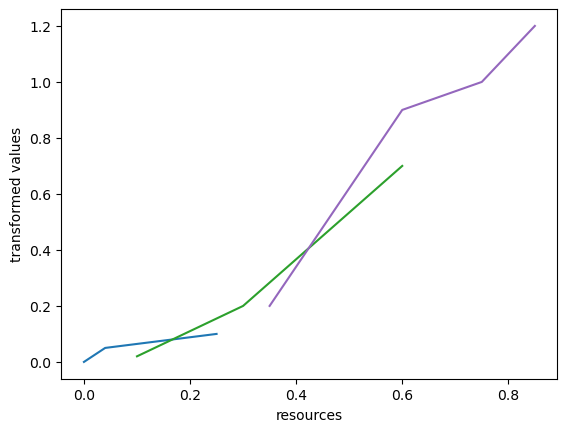

In [4]:
# Compute non-decreasing segments
start, end = calc_nondecreasing_segments(m_egm, vt_egm)

# Plot them, and store them as [m, v] pairs
segments = []
for j in range(len(start)):
    idx = range(start[j], end[j] + 1)
    plt.plot(m_egm[idx], vt_egm[idx])
    segments.append([m_egm[idx], vt_egm[idx]])

plt.xlabel("resources")
plt.ylabel("transformed values")
plt.show()

The next step is to produce the upper-envelope of these segments: a line comprised of the points that are not under any other segment. This is done by HARK's `upper_envelope`function. We now apply it and plot the result

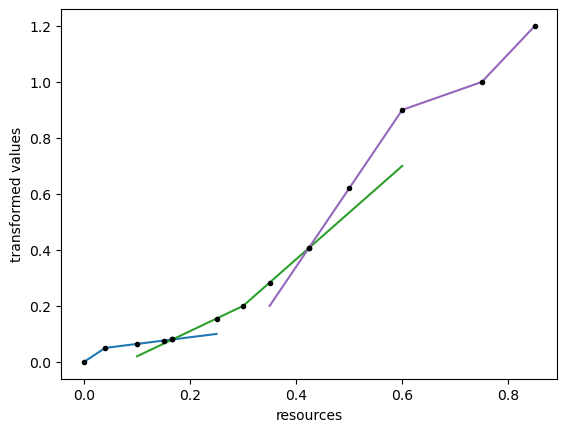

In [5]:
# The function defines the upper envelope over a new grid, which it
# uses to interpolate each of the non-decreasing segments.
m_upper, v_upper, inds_upper = upper_envelope(segments)

for j in range(len(start)):
    idx = range(start[j], end[j] + 1)
    plt.plot(m_egm[idx], vt_egm[idx])
plt.plot(m_upper, v_upper, ".k")
plt.xlabel("resources")
plt.ylabel("transformed values")
plt.show()

And there we have it! a monotonic value without the sub-optimal points or reverse jumps!

Having introduced the main tools, we are now ready to apply DCEGM to a simple example.

# An example: writing a will
### Author: [Mateo Velásquez-Giraldo](https://mv77.github.io/)

We now present a basic example to illustrate the use of the previous tools in solving dynamic optimization problems with discrete and continuous decisions.

The model represents an agent that lives for three periods and decides how much of his resources to consume in each of them. On the second period, he must additionally decide whether to hire a lawyer to write a will. Having a will has the upside of allowing the agent to leave a bequest in his third and last period of life, which gives him utility, but has the downside that the lawyer will charge a fraction of his period 3 resources.

On each period, the agent receives a deterministic amount of resources $w$. The problem, therefore, is fully deterministic.

I now present the model formally, solving it backwards.

But first, some setup and calibration:

In [6]:
# Import tools for linear interpolation and finding optimal
# discrete choices.

# Import CRRA utility (and related) functions from HARK

# Solution method parameters
aGrid = np.linspace(0, 8, 400)  # Savings grid for EGM.

# Model parameters

# Parameters that need to be fixed
# Relative risk aversion. This is fixed at 2 in order to mantain
# the analytical solution that we use, from Carroll (2000)
CRRA = 2

# Parameters that can be changed.
w = 1  # Deterministic wage per period.
# Fraction of resources charged by lawyer for writing a will.
willCstFac = 0.35
DiscFac = 0.98  # Time-discount factor.

# Define utility (and related) functions


def u(x):
    return CRRAutility(x, CRRA)


def uP(x):
    return CRRAutilityP(x, CRRA)


def uPinv(x):
    return CRRAutilityP_inv(x, CRRA)


# Create a grid for market resources
mGrid = (aGrid - aGrid[0]) * 1.5
mGridPlots = np.linspace(w, 10 * w, 100)
mGridPlotsC = np.insert(mGridPlots, 0, 0)

# Transformations for value funtion interpolation


def vTransf(x):
    return np.exp(x)


def vUntransf(x):
    return np.log(x)

# The third (last) period of life

In the last period of life, the agent's problem is determined by his total amount of resources $m_3$ and a state variable $W$ that indicates whether he wrote a will ($W=1$) or not ($W=0$).

### The agent without a will

An agent who does not have a will simply consumes all of his available resources. Therefore, his value and consumption functions will be:

\begin{equation}
V_3(m_3,W=0) = u(m_3)
\end{equation}

\begin{equation}
c_3(m_3, W=0) = m_3
\end{equation}

Where $u(\cdot)$ gives the utility from consumption. We assume a CRRA specification $u(c) = \frac{c^{1-\rho}}{1-\rho}$.

### The agent with a will

An agent who wrote a will decides how to allocate his available resources $m_3$ between his consumption and a bequest. We assume an additive specification for the utility of a given consumption-bequest combination that follows a particular case in [Carroll (2000)](http://www.econ2.jhu.edu/people/ccarroll/Why.pdf). The component of utility from leaving a bequest $x$ is assumed to be $\ln (x+1)$. Therefore, the agent's value function is

\begin{equation}
V_3(m_3, W=1) = \max_{0\leq c_3 \leq m_3} u(c_3) + \ln(m_3 - c_3 + 1)
\end{equation}

For ease of exposition we consider the case $\rho = 2$, where [Carroll (2000)](http://www.econ2.jhu.edu/people/ccarroll/Why.pdf) shows that the optimal consumption level is given by

\begin{equation}
c_3(m_3, W=1) = \min \left[m_3, \frac{-1 + \sqrt{1 + 4(m_3+1)}}{2} \right].
\end{equation}

The consumption function shows that $m_3=1$ is the level of resources at which an important change of behavior occurs: agents leave bequests only for $m_3 > 1$. Since an important change of behavior happens at this point, we call it a 'kink-point' and add it to our grids.

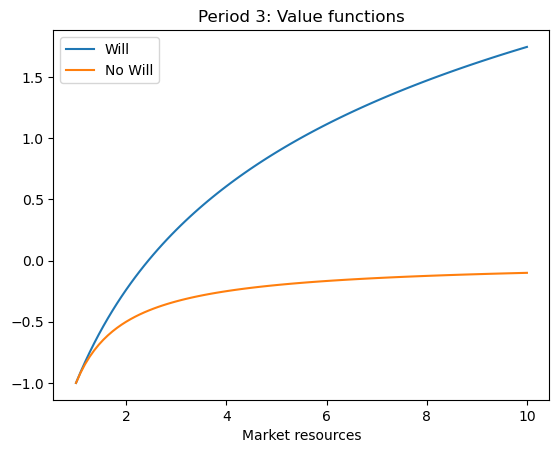

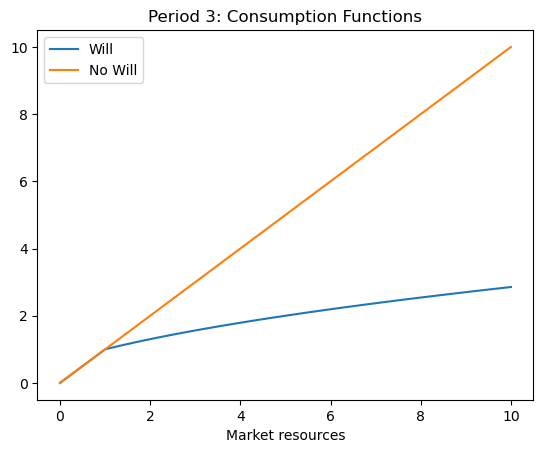

In [7]:
# Agent without a will
mGrid3_no = mGrid
cGrid3_no = mGrid
vGrid3_no = u(cGrid3_no)

# Create functions
c3_no = LinearInterp(mGrid3_no, cGrid3_no)  # (0,0) is already here.
vT3_no = LinearInterp(mGrid3_no, vTransf(vGrid3_no), lower_extrap=True)


def v3_no(x):
    return vUntransf(vT3_no(x))


# Agent with a will

# Define an auxiliary function with the analytical consumption expression


def c3will(m):
    return np.minimum(m, -0.5 + 0.5 * np.sqrt(1 + 4 * (m + 1)))


# Find the kink point
mKink = 1.0
indBelw = mGrid < mKink
indAbve = mGrid > mKink

mGrid3_wi = np.concatenate([mGrid[indBelw], np.array([mKink]), mGrid[indAbve]])

cGrid3_wi = c3will(mGrid3_wi)

cAbve = c3will(mGrid[indAbve])
beqAbve = mGrid[indAbve] - c3will(mGrid[indAbve])
vGrid3_wi = np.concatenate(
    [u(mGrid[indBelw]), u(np.array([mKink])), u(cAbve) + np.log(1 + beqAbve)]
)

# Create functions
c3_wi = LinearInterp(mGrid3_wi, cGrid3_wi)  # (0,0) is already here
vT3_wi = LinearInterp(mGrid3_wi, vTransf(vGrid3_wi), lower_extrap=True)


def v3_wi(x):
    return vUntransf(vT3_wi(x))


plt.figure()

plt.plot(mGridPlots, v3_wi(mGridPlots), label="Will")
plt.plot(mGridPlots, v3_no(mGridPlots), label="No Will")
plt.title("Period 3: Value functions")
plt.xlabel("Market resources")
plt.legend()
plt.show()

plt.plot(mGridPlotsC, c3_wi(mGridPlotsC), label="Will")
plt.plot(mGridPlotsC, c3_no(mGridPlotsC), label="No Will")
plt.title("Period 3: Consumption Functions")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# The second period

On the second period, the agent takes his resources as given (the only state variable) and makes two decisions:
- Whether to write a will or not.
- What fraction of his resources to consume.

These decisions can be seen as happening sequentially: the agent first decides whether to write a will or not, and then consumes optimally in accordance with his previous decision. Since we solve the model backwards in time, we first explore the consumption decision, conditional on the choice of writing a will or not.

## An agent who decides not to write a will

After deciding not to write a will, an agent solves the optimization problem expressed in the following conditional value function

\begin{equation}
\begin{split}
\nu (m_2|w=0) &= \max_{0\leq c \leq m_2} u(c) + \beta V_3(m_3,W=0)\\
s.t.&\\
m_3 &= m_2 - c + w
\end{split}
\end{equation}

We can approximate a solution to this problem through the method of endogenous gridpoints. This yields approximations to $\nu(\cdot|w=0)$ and $c_2(\cdot|w=0)$

In [8]:
# Second period, not writing a will

# Compute market resources at 3 with and without a will
mGrid3_cond_nowi = aGrid + w
# Compute marginal value of assets in period 3 for each ammount of savings in 2
vPGrid3_no = uP(c3_no(mGrid3_cond_nowi))
# Get consumption through EGM inversion of the euler equation
cGrid2_cond_no = uPinv(DiscFac * vPGrid3_no)

# Get beginning-of-period market resources
mGrid2_cond_no = aGrid + cGrid2_cond_no

# Compute value function
vGrid2_cond_no = u(cGrid2_cond_no) + DiscFac * v3_no(mGrid3_cond_nowi)

# Create interpolating value and consumption functions
vT2_cond_no = LinearInterp(mGrid2_cond_no, vTransf(vGrid2_cond_no), lower_extrap=True)


def v2_cond_no(x):
    return vUntransf(vT2_cond_no(x))


c2_cond_no = LinearInterp(
    np.insert(mGrid2_cond_no, 0, 0), np.insert(cGrid2_cond_no, 0, 0)
)

## An agent who decides to write a will

An agent who decides to write a will also solves for his consumption dinamically. We assume that the lawyer that helps the agent write his will takes some fraction $\tau$ of his total resources in period 3. Therefore, the evolution of resources is given by $m_3 = (1-\tau)(m_2 - c_2 + w)$. The conditional value function of the agent is therefore:

\begin{equation}
\begin{split}
\nu (m_2|w=1) &= \max_{0\leq c \leq m_2} u(c) + \beta V_3(m_3,W=1)\\
s.t.&\\
m_3 &= (1-\tau)(m_2 - c + w)
\end{split}
\end{equation}

We also approximate a solution to this problem using the EGM. This yields approximations to $\nu(\cdot|w=1)$ and $c_2(\cdot|w=1)$.

In [9]:
# Second period, writing a will

# Compute market resources at 3 with and without a will
mGrid3_cond_will = (1 - willCstFac) * (aGrid + w)
# Compute marginal value of assets in period 3 for each ammount of savings in 2
vPGrid3_wi = uP(c3_wi(mGrid3_cond_will))
# Get consumption through EGM inversion of the euler equation
cGrid2_cond_wi = uPinv(DiscFac * (1 - willCstFac) * vPGrid3_wi)
# Get beginning-of-period market resources
mGrid2_cond_wi = aGrid + cGrid2_cond_wi

# Compute value function
vGrid2_cond_wi = u(cGrid2_cond_wi) + DiscFac * v3_wi(mGrid3_cond_will)

# Create interpolating value and consumption functions
vT2_cond_wi = LinearInterp(mGrid2_cond_wi, vTransf(vGrid2_cond_wi), lower_extrap=True)


def v2_cond_wi(x):
    return vUntransf(vT2_cond_wi(x))


c2_cond_wi = LinearInterp(
    np.insert(mGrid2_cond_wi, 0, 0), np.insert(cGrid2_cond_wi, 0, 0)
)

## The decision whether to write a will or not

With the conditional value functions at hand, we can now express and solve the decision of whether to write a will or not, and obtain the unconditional value and consumption functions.

\begin{equation}
V_2(m_2) = \max \{ \nu (m_2|w=0), \nu (m_2|w=1) \}
\end{equation}

\begin{equation}
w^*(m_2) = \arg \max_{w \in \{0,1\}} \{ \nu (m_2|w=w) \}
\end{equation}

\begin{equation}
c_2(m_2) = c_2(m_2|w=w^*(m_2))
\end{equation}

We now construct these objects.

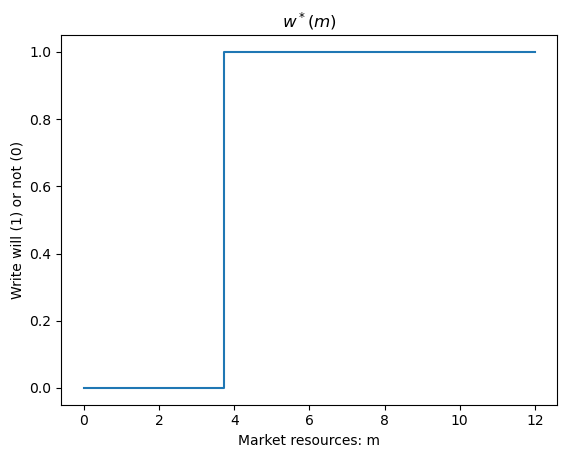

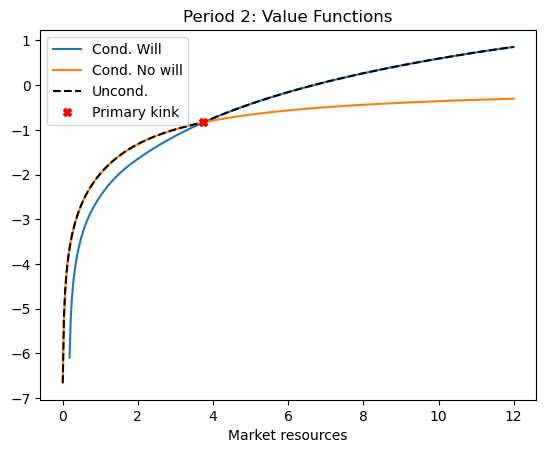

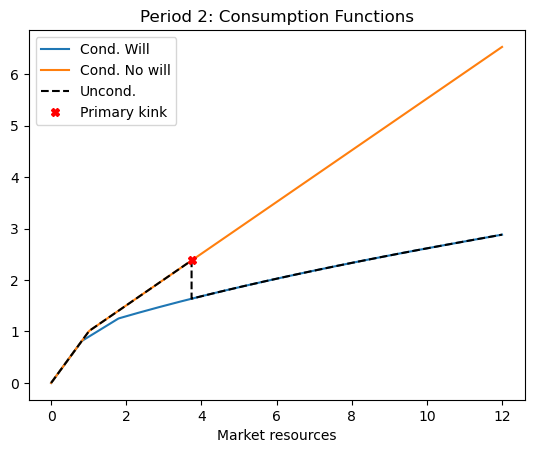

In [10]:
# We can use the upper_envelope function to find which action
# is optimal over the common grid of market resources, and
# insert the exact point in which the two actions yield equal value
# into the grid
m2_env, vt2_env, inds2_env = upper_envelope(
    [[mGrid, vT2_cond_no(mGrid)], [mGrid, vT2_cond_wi(mGrid)]]
)

# Plot the optimal decision rule
plt.plot(m2_env, inds2_env)
plt.title("$w^*(m)$")
plt.ylabel("Write will (1) or not (0)")
plt.xlabel("Market resources: m")
plt.show()

# With the decision rule, we can find unconditional consumption
c2_env = np.zeros_like(m2_env) + np.nan
c2_env[inds2_env == 0] = c2_cond_no(m2_env[inds2_env == 0])
c2_env[inds2_env == 1] = c2_cond_wi(m2_env[inds2_env == 1])

# And create the unconditional consumption and value functions
vT2 = LinearInterp(m2_env, vt2_env, lower_extrap=True)


def v2(x):
    return vUntransf(vT2(x))


c2 = LinearInterp(m2_env, c2_env, lower_extrap=True)

# The 'kink' is where the optimal action changes. Find its position to plot it
kink_idx = np.where(np.diff(inds2_env) != 0.0)

# Plot the conditional and unconditional value functions
plt.plot(m2_env, v2_cond_wi(m2_env), label="Cond. Will")
plt.plot(m2_env, v2_cond_no(m2_env), label="Cond. No will")
plt.plot(m2_env, v2(m2_env), "k--", label="Uncond.")
plt.plot(m2_env[kink_idx], v2(m2_env[kink_idx]), "rX", label="Primary kink")
plt.title("Period 2: Value Functions")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# Plot the conditional and unconditional consumption
# functions
plt.plot(m2_env, c2_cond_wi(m2_env), label="Cond. Will")
plt.plot(m2_env, c2_cond_no(m2_env), label="Cond. No will")
plt.plot(m2_env, c2(m2_env), "k--", label="Uncond.")
plt.plot(m2_env[kink_idx], c2(m2_env[kink_idx]), "rX", label="Primary kink")
plt.title("Period 2: Consumption Functions")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# The first period

In the first period, the agent simply observes his market resources and decides what fraction of them to consume. His problem is represented by the following value function

\begin{equation}
\begin{split}
V (m_1) &= \max_{0\leq c \leq m_1} u(c) + \beta V_2(m_2)\\
s.t.&\\
m_2 &= m_1 - c + w.
\end{split}
\end{equation}

Although this looks like a simple problem, there are complications introduced by the kink in $V_2(\cdot)$, which is clearly visible in the plot from the previous block. Particularly, note that $V_2'(\cdot)$ and $c_2(\cdot)$ are not monotonic: there are now multiple points $m$ for which the slope of $V_2(m)$ is equal. Thus, the Euler equation becomes a necessary but not sufficient condition for optimality and the traditional EGM inversion step can generate non-monotonic endogenous $m$ gridpoints.

We now illustrate this phenomenon.

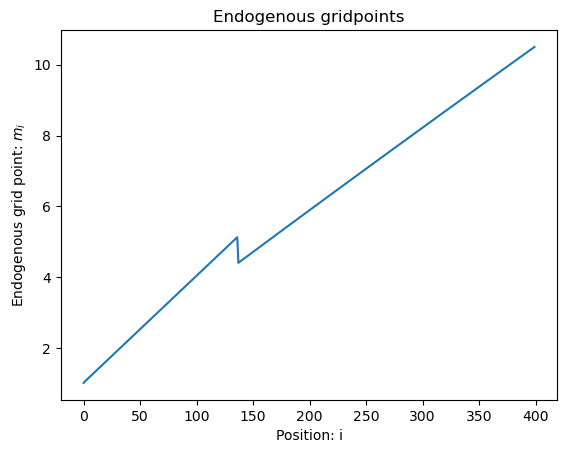

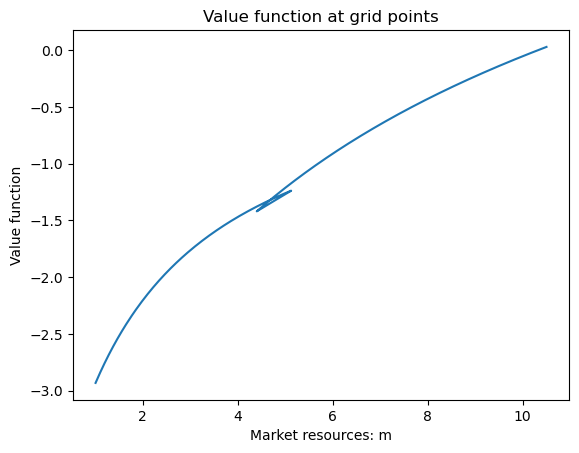

In [11]:
# EGM step

# Period 2 resources implied by the exogenous savings grid
mGrid2 = aGrid + w
# Envelope condition
vPGrid2 = uP(c2(mGrid2))
# Inversion of the euler equation
cGrid1 = uPinv(DiscFac * vPGrid2)
# Endogenous gridpoints
mGrid1 = aGrid + cGrid1
vGrid1 = u(cGrid1) + DiscFac * v2(mGrid2)

plt.plot(mGrid1)
plt.title("Endogenous gridpoints")
plt.xlabel("Position: i")
plt.ylabel("Endogenous grid point: $m_i$")
plt.show()


plt.plot(mGrid1, vGrid1)
plt.title("Value function at grid points")
plt.xlabel("Market resources: m")
plt.ylabel("Value function")
plt.show()

The previous cell applies the endogenous gridpoints method to the first period problem. The plots illustrate that the sequence of resulting endogenous gridpoints $\{m_i\}_{i=1}^N$ is not monotonic. This results in intervals of market resources over which we have multiple candidate values for the value function. This is the point where we must apply the upper envelope function illustrated above.

We finally use the resulting consumption and value grid points to create the first period value and consumption functions.

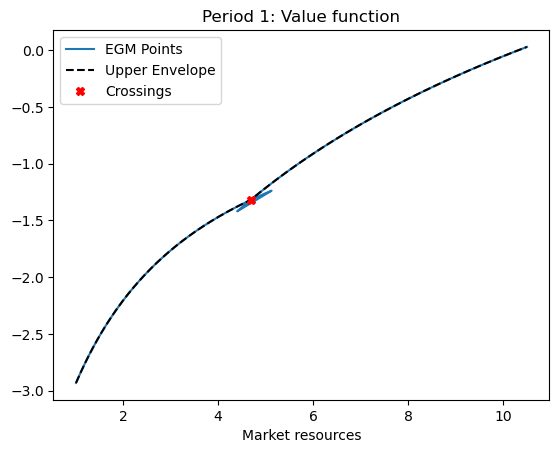

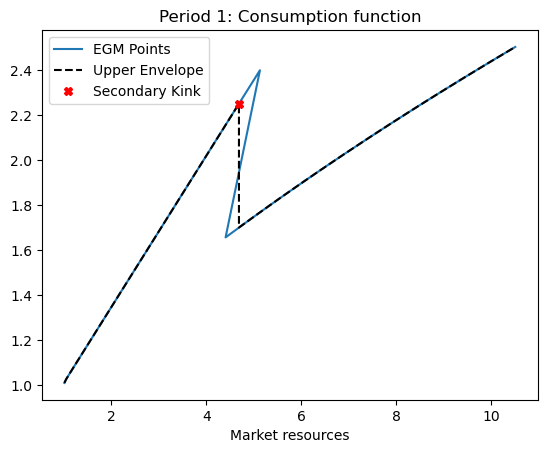

In [12]:
# Calculate envelope
# The function operates with *transformed* value grids
vTGrid1 = vTransf(vGrid1)

# Form non-decreasing segments
start, end = calc_nondecreasing_segments(mGrid1, vTGrid1)

m_segments = []
vT_segments = []
c_segments = []
for j in range(len(start)):
    idx = range(start[j], end[j] + 1)
    m_segments.append(mGrid1[idx])
    vT_segments.append(vTGrid1[idx])
    c_segments.append(cGrid1[idx])

# Get the upper envelope using m and vT
m1_env, vt1_env, idx_1 = upper_envelope(segments=list(zip(m_segments, vT_segments)))

# Store the index at which the optimal segment changes
sec_kink_idx = np.where(np.diff(idx_1) != 0.0)

# Construct enveloped consumption
c1_env = np.zeros_like(m1_env) + np.nan
for k, c_segm in enumerate(c_segments):
    c1_env[idx_1 == k] = LinearInterp(m_segments[k], c_segm)(m1_env[idx_1 == k])

# Create functions
c1_up = LinearInterp(m1_env, c1_env)
v1T_up = LinearInterp(m1_env, vt1_env)


def v1_up(x):
    return vUntransf(v1T_up(x))


# Show that there is a non-monothonicity and that the upper envelope fixes it
plt.plot(mGrid1, vGrid1, label="EGM Points")
plt.plot(m1_env, v1_up(m1_env), "k--", label="Upper Envelope")
plt.plot(m1_env[sec_kink_idx], v1_up(m1_env[sec_kink_idx]), "rX", label="Crossings")
plt.plot()
plt.title("Period 1: Value function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# Plot consumption
plt.plot(mGrid1, cGrid1, label="EGM Points")
plt.plot(m1_env, c1_up(m1_env), "k--", label="Upper Envelope")
plt.plot(
    m1_env[sec_kink_idx], c1_up(m1_env[sec_kink_idx]), "rX", label="Secondary Kink"
)
plt.title("Period 1: Consumption function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# References
[1] Iskhakov, F. , Jørgensen, T. H., Rust, J. and Schjerning, B. (2017), The endogenous grid method for discrete‐continuous dynamic choice models with (or without) taste shocks. Quantitative Economics, 8: 317-365. doi:10.3982/QE643

[2] Carroll, C. D. (2006). The method of endogenous gridpoints for solving dynamic stochastic optimization problems. Economics letters, 91(3), 312-320.

